Source of the code: https://blog.bruce-hill.com/meandering-triangles

# Step 0: get some data 

In [57]:
import math

"""
def elevation_func(x, y):
    return 1 / (2 + math.sin(.2 * math.sqrt(x**2 + .2 * y**2))) * (.75 + .5 * math.sin(.1 * x))
"""

def elevation_func(x, y):
    r = math.sqrt((x - 50)**2 + (y - 50)**2)
    return math.exp(-r**2 *.005)

elevation_data = dict()
WIDTH, HEIGHT = 100, 100

SPACING = 1

for x in range(0, WIDTH, SPACING):
    for y in range(0, HEIGHT, SPACING):
        elevation_data[(x, y)] = elevation_func(x, y)

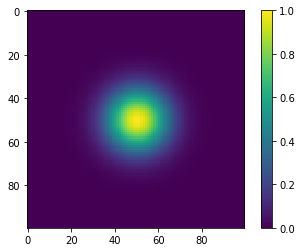

In [75]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def dict_to_2darray(elevation_data, nx, ny):
    img = np.zeros((ny, nx))
    for xy in elevation_data:
        x, y = xy
        img[y, x] = elevation_data[xy]
    return img


img = dict_to_2darray(elevation_data, WIDTH, HEIGHT)

fig, ax = plt.subplots()
m = ax.imshow(img)
plt.colorbar(m)

# Step 1: triangulate 

In [76]:
import collections


Triangle = collections.namedtuple('Triangle', 'v1 v2 v3')


def plot_tri(self, ax):
    v1 = self.v1
    v2 = self.v2
    v3 = self.v3
    ax.plot([v1[0], v2[0], v3[0], v1[0]], [v1[1], v2[1], v3[1], v1[1]], color='black')
    
    
Triangle.plot_tri = plot_tri

triangles = []

for x in range(0, WIDTH - 1, SPACING):
    for y in range(0, HEIGHT - 1, SPACING):
        # upper left triangle
        t1 = Triangle((x, y), (x + SPACING, y), (x, y + SPACING))
        triangles.append(t1)
        # lower right triangle
        t2 = Triangle((x + SPACING, y), (x, y + SPACING), (x + SPACING, y + SPACING))
        triangles.append(t2)

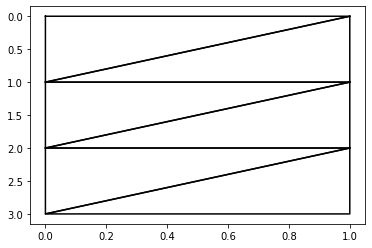

In [77]:
fig, ax = plt.subplots()
ax.invert_yaxis()
for tri in triangles[:6]:
    tri.plot_tri(ax)

# Step 2 and 3: find triangles that intersect contour lines and find the contour line segments

In [78]:
Edge = collections.namedtuple("Edge", "e1 e2")


def plot_edge(self, ax):
    e1 = self.e1
    e2 = self.e2
    ax.plot([e1[0], e2[0]], [e1[1], e2[1]], color='blue')


Edge.plot_edge = plot_edge


def make_contour_segments(triangles, elevation_data, threshold=0.5):
    """Returns a list of contour segments from a collection of triangles."""
    contour_segments = []
    for triangle in triangles:
        below = [vertex for vertex in triangle if elevation_data[vertex] < threshold]
        above = [vertex for vertex in triangle if elevation_data[vertex] >= threshold]
        # cases where there is no contour line passing in the triangle
        if len(below) == 0 or len(above) == 0:
            continue
        # cases where there is a contour line
        minority = above if len(above) < len(below) else below
        majority = above if len(above) > len(below) else below

        contour_points = []
        crossed_edges = (Edge(minority[0], majority[0]),
                         Edge(minority[0], majority[1]))

        for triangle_edge in crossed_edges:
            e1, e2 = triangle_edge.e1, triangle_edge.e2
            how_far = ((threshold - elevation_data[e2]) / (elevation_data[e1] - elevation_data[e2]))
            crossing_point = (how_far * e1[0] + (1 - how_far) * e2[0],
                              how_far * e1[1] + (1 - how_far) * e2[1])
            contour_points.append(crossing_point)
        contour_segments.append(Edge(contour_points[0], contour_points[1]))
    return contour_segments

Let's make a method out of this and visualize the result on a couple of different triangles

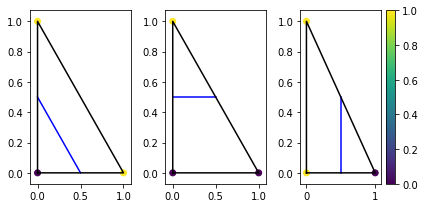

In [79]:
test_triangles = [[Triangle((0, 0), (0, 1), (1, 0))]] * 3
test_elevation_data = [{(0, 0): 0, (0, 1): 1, (1, 0): 1},
                       {(0, 0): 0, (0, 1): 1, (1, 0): 0},
                       {(0, 0): 1, (0, 1): 1, (1, 0): 0}]

fig, axes = plt.subplots(ncols=3, figsize=(6, 3))
for ind, (test_tris, test_data) in enumerate(zip(test_triangles, test_elevation_data)):
    contour_segments = make_contour_segments(test_tris, test_data, threshold=0.5)
    for edge in contour_segments:
        edge.plot_edge(axes[ind])
    test_tris[0].plot_tri(axes[ind])
    array_data = np.c_[list(test_data.keys()), list(test_data.values())]
    m = axes[ind].scatter(array_data[:, 0], array_data[:, 1], c=array_data[:, 2])
plt.colorbar(m)
plt.tight_layout()

We can recreate some of the animated data from the example tutorial on squares and not just triangles.

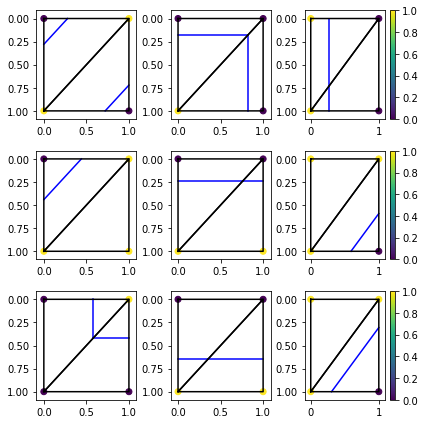

In [80]:
test_triangles = [[Triangle((0, 0), (0, 1), (1, 0)), Triangle((0, 1), (1, 0), (1, 1))]] * 9
test_elevation_data = [{(0, 0): 0, (0, 1): 1, (1, 0): 1, (1, 1): 0},
                       {(0, 0): 0, (0, 1): 1, (1, 0): 0, (1, 1): 0},
                       {(0, 0): 1, (0, 1): 1, (1, 0): 0, (1, 1): 0},
                       {(0, 0): 0, (0, 1): 1, (1, 0): 1, (1, 1): 1},
                       {(0, 0): 0, (0, 1): 1, (1, 0): 0, (1, 1): 1},
                       {(0, 0): 1, (0, 1): 1, (1, 0): 1, (1, 1): 0},
                       {(0, 0): 0, (0, 1): 0, (1, 0): 1, (1, 1): 0},
                       {(0, 0): 0, (0, 1): 1, (1, 0): 0, (1, 1): 1},
                       {(0, 0): 1, (0, 1): 1, (1, 0): 1, (1, 1): 0}]

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(6, 6))
for ind, (test_tris, test_data) in enumerate(zip(test_triangles, test_elevation_data)):
    ax = axes.ravel()[ind]
    ax.invert_yaxis()
    threshold = 1/6 + np.random.rand()*2 / 3
    contour_segments = make_contour_segments(test_tris, test_data, threshold)
    for edge in contour_segments:
        edge.plot_edge(ax)
    for tri in test_tris:
        tri.plot_tri(ax)
    array_data = np.c_[list(test_data.keys()), list(test_data.values())]
    m = ax.scatter(array_data[:, 0], array_data[:, 1], c=array_data[:, 2])
plt.colorbar(m, ax=axes[0, 2])
plt.colorbar(m, ax=axes[1, 2])
plt.colorbar(m, ax=axes[2, 2])
plt.tight_layout()

Let's visualize the segments on the larger triangle data.

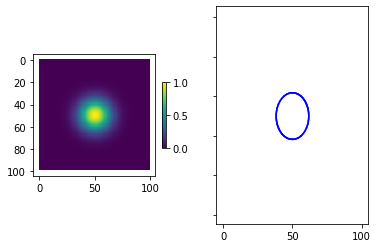

In [81]:
contour_segments = make_contour_segments(triangles, elevation_data, threshold=0.5)

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
m = ax[0].imshow(img)
plt.colorbar(m, ax=ax[0], shrink=0.3)
for segment in contour_segments:
    segment.plot_edge(ax[1])

# Step 4: joining up the segments

The above data just consists on segments that were obtained on each triangle. We would like to have fully connected lines, not just segments.

In [82]:
contour_segments = make_contour_segments(triangles, elevation_data, threshold=0.5)

unassigned_segments = set(contour_segments)

# building a mapping from a segment to its points
points2segments = collections.defaultdict(set)
for segment in contour_segments:
    points2segments[segment.e1].add(segment)
    points2segments[segment.e2].add(segment)
    
contour_lines = []
while unassigned_segments:
    line = collections.deque(unassigned_segments.pop())
    while True:
        tail_point = line[-1]
        tail_candidates = points2segments[tail_point].intersection(unassigned_segments)
        if tail_candidates:
            tail = tail_candidates.pop()
            line.append(tail.e1 if tail.e2 == tail_point else tail.e2)
            unassigned_segments.remove(tail)
            continue
        head_point = line[0]
        head_candidates = points2segments[head_point].intersection(unassigned_segments)
        if head_candidates:
            head = head_candidates.pop()
            line.appendleft(head.e1 if head.e2 == head_point else head.e2)
            unassigned_segments.remove(head)
            continue
        if not tail_candidates and not head_candidates:
            contour_lines.append(list(line))
            break

How many lines did we find?

In [89]:
len(contour_lines)

32

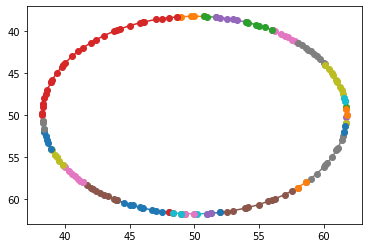

In [90]:
fig, ax = plt.subplots()
ax.invert_yaxis()
for line in contour_lines[:]:
    line = np.array(line)
    ax.plot(line[:, 0], line[:, 1], '-o')

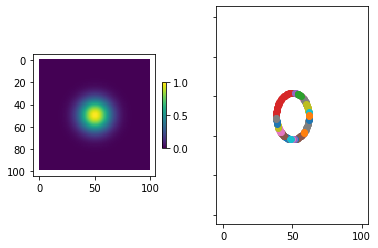

In [91]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
m = ax[0].imshow(img)
plt.colorbar(m, ax=ax[0], shrink=0.3)
for segment in contour_segments:
    segment.plot_edge(ax[1])
for line in contour_lines[:]:
    line = np.array(line)
    ax[1].plot(line[:, 0], line[:, 1], '-o')

So it turns out that this does not work as expected: I expected to find one single connected line but end up with a bunch of not completely connected segments (testing the original implementation is even worse since there are more segments). 

Why? Due to floating point representation errors. We're matching the line segments based on a the intersection coordinates. It seems to me that rounding errors cut off the lines.

Is there a better way? Certainly! To get the intersection, we could match the segments based on the vertices that they are crossing and add the coordinates as second thoughts. But it makes the writing a little more tricky.